In [1]:
# Set up libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sqlalchemy import create_engine
from configparser import ConfigParser
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 


Bad key "text.kerning_factor" on line 4 in
C:\Users\HOME\Anaconda3\envs\SEGP\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Configure the connection
config = ConfigParser()
config.read("config.ini")
options = config["DataBase"]

engine = create_engine("mysql://" + options["user"] + ":" + options["passwd"] + "@" + options["host"] + "/" + options["database"])
engine.connect()

In [3]:
# Set up the SQL command and turn into dataframe
stat_2 = "SELECT * FROM dublinbikes.dynamic_data WHERE number = 4"
sql_df = pd.read_sql(stat_2,engine)
print(sql_df.shape)
sql_df.head(5)

(9782, 6)


,number,last_update,bike_stands,available_bike_stands,available_bikes,status
0,4,1581417900,20,17,3,OPEN
1,4,1581418380,20,17,3,OPEN
2,4,1581418800,20,17,3,OPEN
3,4,1581419340,20,16,4,OPEN
4,4,1581419940,20,16,4,OPEN


In [4]:
# check for duplicates
print("Number of duplicate rows: ", sql_df.duplicated().sum())
print("Number of duplicate columns: ", sql_df.T.duplicated().sum())

Number of duplicate rows:  0
Number of duplicate columns:  0


In [5]:
# looking at 'last_update'
count, count2 = 0,0
for line in sql_df['last_update']:
    if len(str(line)) > 10:
        count += 1
    else:
        count2 += 1
        
print("Last update in len 10 format: ", count2)
print("Last update in len 13 format: ", count)

Last update in len 10 format:  4639
Last update in len 13 format:  5143


In [6]:
# converting 'last_update' enties from 13 digits to the required 10
for i in range(sql_df.shape[0]):
    convert = str(sql_df['last_update'][i])
    if len(convert) > 10:
        sql_df.at[i,'last_update'] = int(convert[:10])


In [7]:
print("Number of duplicate rows: ", sql_df.duplicated().sum())
print("Number of duplicate columns: ", sql_df.T.duplicated().sum())

Number of duplicate rows:  1
Number of duplicate columns:  0


In [8]:
sql_df[sql_df.duplicated(keep=False)]

,number,last_update,bike_stands,available_bike_stands,available_bikes,status
4638,4,1583234283,20,6,13,OPEN
4639,4,1583234283,20,6,13,OPEN


In [9]:
sql_df = sql_df.drop_duplicates()
sql_df = sql_df.reset_index(drop=True)
print(sql_df.shape)
sql_df.head(5)


(9781, 6)


,number,last_update,bike_stands,available_bike_stands,available_bikes,status
0,4,1581417900,20,17,3,OPEN
1,4,1581418380,20,17,3,OPEN
2,4,1581418800,20,17,3,OPEN
3,4,1581419340,20,16,4,OPEN
4,4,1581419940,20,16,4,OPEN


In [10]:
# moving target feature to end
sql_df = sql_df[['number', 'last_update', 'bike_stands', 'available_bike_stands', 'status', 'available_bikes']]
sql_df.head(5)

,number,last_update,bike_stands,available_bike_stands,status,available_bikes
0,4,1581417900,20,17,OPEN,3
1,4,1581418380,20,17,OPEN,3
2,4,1581418800,20,17,OPEN,3
3,4,1581419340,20,16,OPEN,4
4,4,1581419940,20,16,OPEN,4


In [11]:
# convert update to datetime
sql_df['last_update'] = sql_df['last_update'].apply(lambda x: datetime.fromtimestamp(x))
sql_df.head(5)

,number,last_update,bike_stands,available_bike_stands,status,available_bikes
0,4,2020-02-11 10:45:00,20,17,OPEN,3
1,4,2020-02-11 10:53:00,20,17,OPEN,3
2,4,2020-02-11 11:00:00,20,17,OPEN,3
3,4,2020-02-11 11:09:00,20,16,OPEN,4
4,4,2020-02-11 11:19:00,20,16,OPEN,4


In [12]:
# adding day of the week column
sql_df.insert(2, 'day_of_week', 0)
sql_df['day_of_week'] = sql_df['last_update'].apply(lambda x: x.dayofweek )
sql_df

,number,last_update,day_of_week,bike_stands,available_bike_stands,status,available_bikes
0,4,2020-02-11 10:45:00,1,20,17,OPEN,3
1,4,2020-02-11 10:53:00,1,20,17,OPEN,3
2,4,2020-02-11 11:00:00,1,20,17,OPEN,3
3,4,2020-02-11 11:09:00,1,20,16,OPEN,4
4,4,2020-02-11 11:19:00,1,20,16,OPEN,4
...,...,...,...,...,...,...,...
9776,4,2020-03-31 15:14:02,1,20,4,OPEN,16
9777,4,2020-03-31 15:24:10,1,20,8,OPEN,12
9778,4,2020-03-31 15:34:19,1,20,8,OPEN,12
9779,4,2020-03-31 15:44:28,1,20,8,OPEN,12


In [13]:
# remove lines of repeated data
r_day, r_stand, r_bike = 0,0,0
clean_sql_df = pd.DataFrame()
for i in range(sql_df.shape[0]):
    c_day = sql_df['day_of_week'][i]
    c_stand = sql_df['available_bike_stands'][i]
    c_bike = sql_df['available_bikes'][i]
    if r_day == c_day and r_stand == c_stand and r_bike == c_bike:
        continue
    else:
        r_day, r_stand, r_bike = c_day, c_stand, c_bike
        clean_sql_df = clean_sql_df.append([sql_df.iloc[i]])


clean_sql_df = clean_sql_df.reset_index(drop=True)
clean_sql_df

,number,last_update,day_of_week,bike_stands,available_bike_stands,status,available_bikes
0,4,2020-02-11 10:45:00,1,20,17,OPEN,3
1,4,2020-02-11 11:09:00,1,20,16,OPEN,4
2,4,2020-02-11 11:41:00,1,20,17,OPEN,3
3,4,2020-02-11 11:42:00,1,20,16,OPEN,4
4,4,2020-02-11 11:43:00,1,20,15,OPEN,5
...,...,...,...,...,...,...,...
3067,4,2020-03-31 09:17:16,1,20,0,OPEN,20
3068,4,2020-03-31 09:18:34,1,20,1,OPEN,19
3069,4,2020-03-31 09:34:59,1,20,2,OPEN,18
3070,4,2020-03-31 15:14:02,1,20,4,OPEN,16


In [14]:
#This function is used repeatedly to compute all metrics
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    #print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))

In [15]:
# Preparing Data
cont_features = ['day_of_week']
X = clean_sql_df[cont_features]
y = clean_sql_df.available_bikes

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# print(X_train)
# train the model
# Train on the training sample and test on the test sample.
linreg = LinearRegression().fit(X_train, y_train)

In [16]:
train_predictions = linreg.predict(X_train)
print("Actual values of training:\n", y_train)
print("Predictions on training:", train_predictions)
printMetrics(y_train, train_predictions)

Actual values of training:
 676      9
1283    14
2412     7
2115    19
2656     3
        ..
763      2
835     11
1653    13
2607     7
2732     4
Name: available_bikes, Length: 2150, dtype: int64
Predictions on training: [7.30975688 7.30975688 7.30975688 ... 6.51199229 6.11311    7.30975688]

MAE:  4.9235329428320735
RMSE:  5.738197873914622
R2:  0.014148575726917967


In [17]:
test_predictions = linreg.predict(X_test)
print("Actual values of training:\n", y_test)
print("Predictions on training:", test_predictions)
printMetrics(y_test, test_predictions)

Actual values of training:
 1430    18
779      0
643     20
1853     1
1907     1
        ..
1499    18
653     19
781      1
2700     8
1856     0
Name: available_bikes, Length: 922, dtype: int64
Predictions on training: [7.70863918 7.70863918 7.30975688 7.30975688 7.30975688 7.30975688
 8.50640377 7.70863918 7.70863918 6.51199229 7.30975688 6.51199229
 7.30975688 7.30975688 8.50640377 7.30975688 7.30975688 8.50640377
 6.91087459 7.70863918 7.30975688 6.51199229 7.30975688 7.30975688
 7.70863918 7.30975688 7.30975688 6.91087459 7.30975688 7.30975688
 6.91087459 8.50640377 7.70863918 7.30975688 7.30975688 6.51199229
 7.30975688 6.91087459 6.91087459 7.30975688 7.30975688 8.10752147
 8.10752147 6.91087459 7.30975688 6.91087459 7.70863918 7.70863918
 6.11311    8.10752147 7.70863918 6.11311    7.70863918 6.51199229
 6.91087459 8.50640377 6.51199229 7.70863918 8.10752147 6.51199229
 8.10752147 6.51199229 8.50640377 6.91087459 6.11311    6.91087459
 7.30975688 6.11311    7.70863918 7.7086

In [18]:
# predict whole table
predicted_bikes = linreg.predict(X)
pb_df = clean_sql_df.assign(predicted_bikes=predicted_bikes)

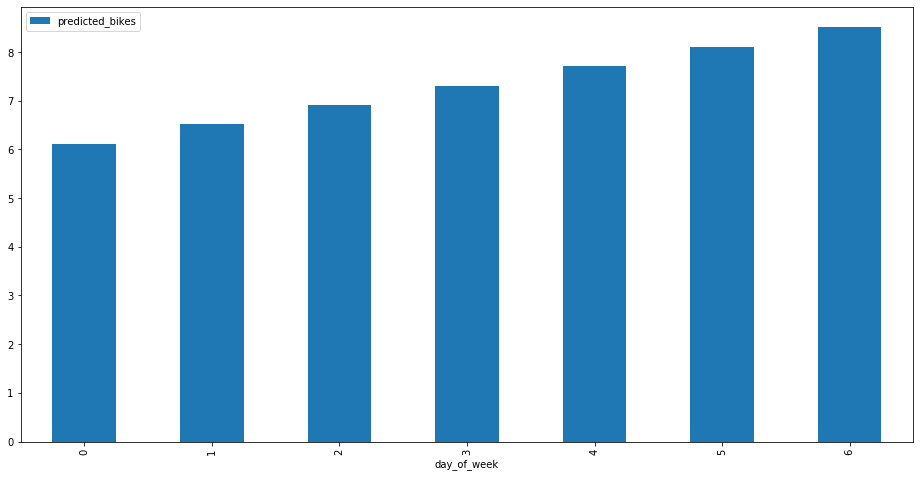

In [19]:
plot_data = pb_df[['day_of_week','predicted_bikes']]
plot_data = plot_data.groupby('day_of_week').mean()
# plot_out = plot_data.plot(x=plot_data[0], y='predicted_bikes',kind='bar', figsize=(16,8))
# plot_data = plot_data.groupby(['day_of_week','predicted_bikes']).count().unstack('predicted_bikes').fillna(0)
plot_out = plot_data.plot(kind='bar', stacked=True, figsize=(16,8))
